In [3]:
import matplotlib.pyplot as plt
import tools.dataTools as dt
from constants import Constants
import figure_params
from tqdm.auto import tqdm
import os
import pickle
from textwrap import wrap
from sklearn.metrics.pairwise import cosine_similarity

import pyaldata as pyal
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from constants import Constants

figure_params.set_rc_params()
figure_params.setup_directories()

SUBFIG_DIR = Constants.FIG_FOLDER + 'fig4/'
if not os.path.exists(SUBFIG_DIR):
    os.makedirs(SUBFIG_DIR)

#run simulations for figure, will take a while to run
# import subprocess
# os.chdir(Constants.PROJ_DIR)
# subprocess.run(["bash", "simulation/fig_simulations/fig4_sims.sh"]) #uncomment code to make datasets if not made yet

import warnings
warnings.filterwarnings("ignore")

In [4]:
seeds = Constants.SEEDS
repertoires = Constants.UNIS
pca_dims = Constants.PCA_DIMS
moveset = dt.get_moveset(repertoires[0])
abr_dict = Constants.REPERTOIRE_ABR_DICTS[moveset]
seed_ex = 1000003

#### Calculate deviation angle

In [5]:
#params
redo = False
perturbation = 'rotation'
pert_set = 'v1'
pert_param = 10.0

for sim_set in ['uni_rad', 'uni_onehot']:
    fname = Constants.PROCESSED_DATA_FOLDER + sim_set + '/deviation_angle.pickle'
    if redo or (not os.path.isfile(fname)):
        rows_list = []
        for seed in tqdm(seeds):
            for j, repertoire in enumerate(repertoires[1:]):
                
                #activity during skill learning
                skill_df = dt.get_pyaldata(sim_set, seed, repertoire, 
                                epoch_fun = Constants.prep_exec_epoch, subtract_mean = False)
                model = pyal.fit_dim_reduce_model(skill_df, PCA(Constants.PCA_DIMS), 'MCx_rates')
                skill_df = pyal.apply_dim_reduce_model(skill_df, model, 'MCx_rates', 'both_pca')
                skill_av_df = pyal.trial_average(skill_df, 'target_param')
                skill_av_df = skill_av_df.sort_values(by = 'target_param', ascending=False) #sort movements

                #activity during adaptation
                pert_df = dt.get_pyaldata(sim_set, seed, repertoire, perturbation, pert_param, pert_set,
                                epoch_fun = Constants.prep_exec_epoch, subtract_mean = False)
                pert_df = pyal.apply_dim_reduce_model(pert_df, model, 'MCx_rates', 'both_pca')
                pert_av_df = pyal.trial_average(pert_df, 'target_param')
                pert_av_df = pert_av_df.sort_values(by = 'target_param', ascending=False)

                #get latent activity for first two reaches and reach after adaptation
                skill_pca_reach1 = np.array(skill_av_df.both_pca.values.tolist())[0]
                skill_pca_reach2 = np.array(skill_av_df.both_pca.values.tolist())[1]
                pert_pca_reach1 = np.array(pert_av_df.both_pca.values.tolist())[0]

                #get adjacent movement vector (between adjacent reaches)
                reach_diff = skill_pca_reach2 - skill_pca_reach1
                reach_diff = np.array([x/np.linalg.norm(x) for x in reach_diff])

                #get adaptation vector (between reaches before and after adaptation)
                pert_diff = pert_pca_reach1 - skill_pca_reach1
                pert_diff = np.array([x/np.linalg.norm(x) for x in pert_diff])
                # ave_pert_diff = np.mean(pert_diff, axis = 0)

                #get deviation angle: calc for each tstep
                angle = np.degrees(np.arccos(np.clip([np.dot(x, y) for x,y in zip(reach_diff,pert_diff)], -1.0,1.0)))

                temp = {
                    'seed': seed,
                    'sim_set': sim_set,
                    'repertoire': repertoire,
                    'perturbation': perturbation,
                    'pert_param': pert_param,
                    'pert_set': pert_set,
                    'adj_movement_vector': reach_diff,
                    'adaptation_vector': pert_diff,
                    'angle': angle,
                }
                rows_list.append(temp)

        angles_df = pd.DataFrame(rows_list)

        # plt.tight_layout()
        with open(fname, 'wb') as f:
            pickle.dump(angles_df, f)

with open(Constants.PROCESSED_DATA_FOLDER + 'uni_rad/deviation_angle.pickle', 'rb') as f:
    angles_df_rad = pickle.load(f)
with open(Constants.PROCESSED_DATA_FOLDER + 'uni_onehot/deviation_angle.pickle', 'rb') as f:
    angles_df_onehot = pickle.load(f)


#### Plot latents with deviation angle

In [6]:
def plot_deviation_angle(sim_set, seed, repertoire, perturbation, pert_param, pert_set, epoch_fun, rel_start, elev = 0, azim = 0, datafile = None):
    fig = plt.figure(figsize = (4,3))

    #activity during skill learning
    skill_df = dt.get_pyaldata(sim_set, seed, repertoire, 
                    epoch_fun = epoch_fun, subtract_mean = False, datafile = datafile)
    model = pyal.fit_dim_reduce_model(skill_df, PCA(Constants.PCA_DIMS), 'MCx_rates')
    skill_df = pyal.apply_dim_reduce_model(skill_df, model, 'MCx_rates', 'both_pca')
    skill_av_df = pyal.trial_average(skill_df, 'target_param')
    skill_av_df = skill_av_df.sort_values(by = 'target_param', ascending=False) #sort movements

    #activity during adaptation
    pert_df = dt.get_pyaldata(sim_set, seed, repertoire, perturbation, pert_param, pert_set,
                    epoch_fun = epoch_fun, subtract_mean = False)
    pert_df = pyal.apply_dim_reduce_model(pert_df, model, 'MCx_rates', 'both_pca')
    pert_av_df = pyal.trial_average(pert_df, 'target_param')
    pert_av_df = pert_av_df.sort_values(by = 'target_param', ascending=False)

    #get latent activity for first two reaches and reach after adaptation
    skill_pca_reach1 = np.array(skill_av_df.both_pca.values.tolist())[0]
    skill_pca_reach2 = np.array(skill_av_df.both_pca.values.tolist())[1]
    pert_pca_reach1 = np.array(pert_av_df.both_pca.values.tolist())[0]

    skill_pca = skill_av_df.both_pca.values.tolist()
    normalization_dist = np.median(np.linalg.norm(np.diff(skill_pca, axis = 1)[:,:,:3],axis = 2)) #only based on first 3 PCs
    print(normalization_dist, 20*normalization_dist)

    # PLOTTING
    ax = fig.add_subplot(projection = '3d')
    #plot before adaptation
    ax = dt.plot_3d(skill_av_df, 'both_pca', [1,2,3], rel_start, ax = ax, elev = elev, azim = azim)
    #plot after adaptation
    ax = dt.plot_3d(pert_av_df, 'both_pca', [1,2,3], rel_start, ax = ax, linestyle = '--', elev = elev, azim = azim)

    tstep = int(skill_pca_reach1.shape[0]/2) #plot vectors at middle of trajectories
    #adj movement vector
    ax.plot([skill_pca_reach1[tstep,0], skill_pca_reach2[tstep,0]], 
        [skill_pca_reach1[tstep,1], skill_pca_reach2[tstep,1]],
        [skill_pca_reach1[tstep,2], skill_pca_reach2[tstep,2]], color = 'r', linewidth = 2)
    #adaptation vector
    ax.plot([skill_pca_reach1[tstep,0], pert_pca_reach1[tstep,0]], 
        [skill_pca_reach1[tstep,1], pert_pca_reach1[tstep,1]],
        [skill_pca_reach1[tstep,2], pert_pca_reach1[tstep,2]], color = 'r', linestyle = '--',linewidth = 2)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    #plot scalebar
    length = 20*normalization_dist/np.sqrt(3)
    offset = length*0.2
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    zmin, zmax = ax.get_zlim()

    if elev > 0:
        z0 = zmin + (zmax-zmin)*0.1  
        z1 = z0 + length
    else:
        z0 = zmax - (zmax-zmin)*0.1
        z1 = z0 - length

    if (elev*azim <0):
        y0 = ymin + (ymax-ymin)*0.1
        y1 = y0 + length
    else:
        y0 = ymax - (ymax-ymin)*0.1
        y1 = y0 - length

    if azim > 0:
        x0 = xmax - (xmax-xmin)*0.1
        x1 = x0 - length
        y0 = ymax - (xmax-xmin)*0.8
        y1 = y0 - length
    else:
        x0 = xmin + (xmax-xmin)*0.8
        x1 = x0 + length

    # y0 = y + (ymax-ymin)*0.03
    # y1 = y - (ymax-ymin)*0.03
    # y = ymin if (elev*azim <0) else ymax
    # z = zmin if elev > 0 else zmax

    ax.plot([x0, x1], [y0, y1], [z0,z1], color = 'k', linewidth = 1.5) #scale bar
    ax.plot([x0 + offset, x0 - offset], [y0 , y0], [z0,z0], color = 'k', linewidth = 1.5) #scale bar
    ax.plot([x1 + offset, x1 - offset], [y1 , y1], [z1,z1], color = 'k', linewidth = 1.5) #scale bar

    # ax.plot([x0, x1], [y, y], [z,z], color = 'k', linewidth = 1.5) #scale bar
    # ax.plot([x0, x0], [y0, y1], [z,z], color = 'k', linewidth = 1.5) #side brackets
    # ax.plot([x1, x1], [y0, y1], [z,z], color = 'k', linewidth = 1.5)
    
    params = '_'.join([sim_set, str(seed), repertoire, perturbation, str(pert_param), pert_set, str(rel_start)])
    plt.tight_layout()
    plt.savefig(SUBFIG_DIR +'dev_angle_3d'+params+'.pdf', format = 'pdf')

    return ax



#### Latent dynamics for angular input network

0.10188318633973473 2.0376637267946944
0.20695489485501206 4.139097897100241


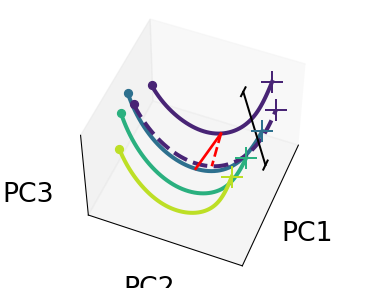

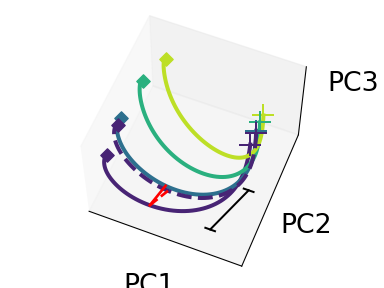

In [7]:
%matplotlib widget 
perturbation = 'rotation'
pert_set = 'v1'
pert_param = 10.0

# angular inputs: preparation
ax = plot_deviation_angle('uni_rad', seed_ex, repertoires[-1], 
    perturbation, pert_param, pert_set, 
    Constants.prep_epoch, int(Constants.WINDOW_prep[0]/Constants.BIN_SIZE), 
    azim = -158, elev = 50)

# angular inputs: exec
ax = plot_deviation_angle('uni_rad', seed_ex, repertoires[-1], 
    perturbation, pert_param, pert_set, 
    Constants.exec_epoch, int(Constants.WINDOW_exec[0]/Constants.BIN_SIZE), 
    azim = -68, elev = 58)

#### Latent dynamics for categorical input network

0.006381452312992721 0.12762904625985444
0.1827340728009183 3.6546814560183662


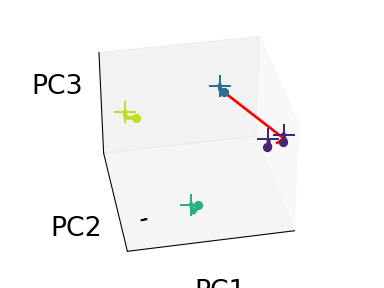

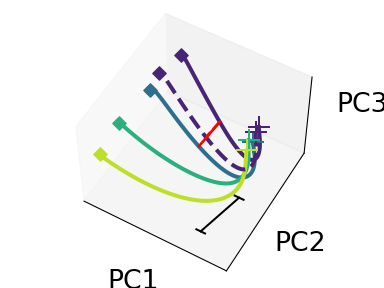

In [8]:
%matplotlib widget 
perturbation = 'rotation'
pert_set = 'v1'
pert_param = 10.0

# onehot inputs: preparation
ax = plot_deviation_angle('uni_onehot', seed_ex, repertoires[-1], 
    perturbation, pert_param, pert_set, 
    Constants.prep_epoch, int(Constants.WINDOW_prep[0]/Constants.BIN_SIZE),
    azim = 101, elev = -145)

#onehot inputs: exec
ax = plot_deviation_angle('uni_onehot', seed_ex, repertoires[-1], 
    perturbation, pert_param, pert_set, 
    Constants.exec_epoch, int(Constants.WINDOW_exec[0]/Constants.BIN_SIZE),
    azim = -120, elev = -127)

#### Structure and congruency

In [9]:
%matplotlib inline

def get_distances(sim_set, seed, repertoire, epoch_fun, ax = None):
    #get data
    init_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun=epoch_fun, subtract_mean = False)
    init_df = pyal.dim_reduce(init_df, PCA(Constants.PCA_DIMS), 'MCx_rates', 'both_pca')
    av_df = pyal.trial_average(init_df, 'target_param')
    av_df = av_df.sort_values(by = 'target_param')
    data = av_df.both_pca.values.tolist()

    n_reaches = len(data)

    #calculate distances between timesteps (for normalization)
    dist_tsteps = np.linalg.norm(np.diff(data, axis = 1),axis = 2)
    dist_m = np.zeros((n_reaches, n_reaches))

    #calculate distances between reaches
    for i in range(n_reaches):
        for j in range(i, n_reaches):
            a = data[i]
            b = data[j]
            dist_m[j][i] = np.median(np.diagonal(scipy.spatial.distance.cdist(a,b,'euclidean')))/np.median(dist_tsteps)
            dist_m[i][j] = dist_m[j][i]
    
    return dist_m

def get_input_RDM(sim_set, repertoire):
    dataset = Constants.SIM_SET_DATA[sim_set]
    data = dt.get_repertoire_data(dataset, repertoire, Constants.SEEDS[0])
    inputs = data['stimulus'][:,-1,1:]
    unique_inputs = np.unique(inputs, axis = 0) 

    #calculate cosine similarity between inputs
    input_sim = np.zeros((len(unique_inputs), len(unique_inputs)))
    for i in range(len(unique_inputs)):
        for j in range(i, len(unique_inputs)):
            input_sim[j][i] = 1 - cosine_similarity(unique_inputs[i].reshape(1,-1), unique_inputs[j].reshape(1,-1))[0][0]
            input_sim[i][j] = input_sim[j][i]

    return input_sim

In [10]:
sim_sets = ['uni_rad', 'uni_onehot']
reps = Constants.UNIS
seeds = Constants.SEEDS

redo = False
fname = Constants.PROCESSED_DATA_FOLDER + \
    '/' + 'neural_distances.pickle'
    
if os.path.isfile(fname) & (not redo):
    with open(fname, 'rb') as f:
        dist_df = pickle.load(f)
else:
    # get neural distances during preparation and execution
    rows = []
    for sim_set in sim_sets:
        for seed in tqdm(seeds):
            for repertoire in reps:

                prep_exec_dist = get_distances(sim_set, seed, repertoire, Constants.prep_exec_epoch)
                rows.append([sim_set, seed, repertoire, prep_exec_dist, 'prep_exec'])

    dist_df = pd.DataFrame(rows, columns = ['sim_set', 'seed', 'repertoire', 'dist', 'epoch'])

    with open(fname, 'wb') as f:
        pickle.dump(dist_df, f)

# get input RDMs
rows = []
for sim_set in sim_sets:
    for repertoire in reps:
        input_sim = get_input_RDM(sim_set, repertoire)
        rows.append([sim_set, repertoire, input_sim])
input_sim_df = pd.DataFrame(rows, columns = ['sim_set', 'repertoire', 'input_sim'])

In [11]:
#merge distances and input similarities
merged_df = pd.merge(dist_df, input_sim_df, on = ['sim_set', 'repertoire'])
merged_df = merged_df[merged_df.repertoire.isin(Constants.UNIS[1:])]
merged_df['opp_sim_set'] = merged_df.apply(lambda x: 'uni_rad' if x['sim_set'] == 'uni_onehot' else 'uni_onehot', axis = 1)

#merge input similarities of opposite sim set
input_sim_df_opp = input_sim_df.copy()
input_sim_df_opp['opp_sim_set'] = input_sim_df_opp['sim_set']
input_sim_df_opp['opp_input_sim'] = input_sim_df_opp['input_sim']
input_sim_df_opp = input_sim_df_opp.drop(columns = ['sim_set', 'input_sim'])
merged_df = pd.merge(merged_df, input_sim_df_opp, on = ['opp_sim_set', 'repertoire'])

#calculate correlations
merged_df['input_corr'] = merged_df.apply(lambda x: scipy.stats.pearsonr(x['input_sim'][np.triu_indices(len(x['input_sim']))], x['dist'][np.triu_indices(len(x['dist']))])[0], axis = 1)

merged_df['input_corr_opp'] = merged_df.apply(lambda x: scipy.stats.pearsonr(x['opp_input_sim'][np.triu_indices(len(x['opp_input_sim']))], x['dist'][np.triu_indices(len(x['dist']))])[0], axis = 1)


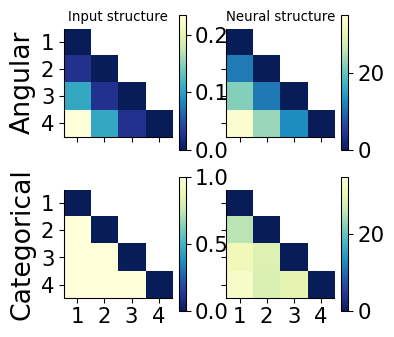

In [14]:
#plot RDMs for input and neural structure
repertoire = reps[-1] 

#prep RDMs
uni_rad_info = merged_df.loc[(merged_df.seed == seed_ex)&(merged_df.repertoire == repertoire)&(merged_df.epoch == 'prep_exec')&(merged_df.sim_set == 'uni_rad')]
uni_onehot_info = merged_df.loc[(merged_df.seed == seed_ex)&(merged_df.repertoire == repertoire)&(merged_df.epoch == 'prep_exec')&(merged_df.sim_set == 'uni_onehot')]

cmap = 'YlGnBu_r'
n_reaches = 4
fig, axs = plt.subplots(2,2, figsize = (4,4), sharex = True, sharey = True)

#input structure for angular inputs
mask = np.tri(uni_rad_info.input_sim.values[0].shape[0], k = 0)
info = axs[0][0].imshow(np.ma.array(uni_rad_info.input_sim.values[0], mask = np.logical_not(mask)), cmap = cmap)
fig.colorbar(info, ax=axs[0][0])

#neural structure for angular inputs
info = axs[0][1].imshow(np.ma.array(uni_rad_info.dist.values[0], mask = np.logical_not(mask)), vmin = 0, vmax = 35, cmap = cmap)
fig.colorbar(info, ax=axs[0][1])

#input structure for categorical inputs
info = axs[1][0].imshow(np.ma.array(uni_onehot_info.input_sim.values[0], mask = np.logical_not(mask)), cmap = cmap)
fig.colorbar(info, ax=axs[1][0])

#neural structure for categorical inputs
info = axs[1][1].imshow(np.ma.array(uni_onehot_info.dist.values[0], mask = np.logical_not(mask)), vmin = 0, vmax = 35, cmap = cmap)
fig.colorbar(info, ax=axs[1][1])

axs[0][0].set_title('Input structure')
axs[0][1].set_title('Neural structure')
axs[0][0].set_ylabel('Angular')
axs[1][0].set_ylabel('Categorical')

for ax in axs.flatten():
    ax.set_xticks(range(0,n_reaches))
    ax.set_xticklabels(range(1,n_reaches+1))
    ax.set_yticks(range(0,n_reaches))
    ax.set_yticklabels(range(1,n_reaches+1))

plt.savefig(SUBFIG_DIR + 'input_neural_structure.pdf', bbox_inches='tight', format = 'pdf')

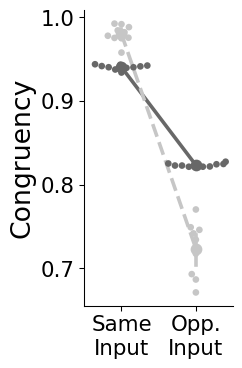

In [15]:
melted_df = pd.melt(merged_df, id_vars=['sim_set', 'seed', 'repertoire', 'epoch'], value_vars=['input_corr_opp', 'input_corr'],
                    var_name='Measure', value_name='input_corr_val')
melted_df.head()
df = melted_df[(melted_df.repertoire == reps[-1])&(melted_df.epoch == 'prep_exec')]

#congruency calculated as correlation between input and neural structure
plt.figure(figsize = (2,4))
g = sns.pointplot(data=df, x='Measure', y='input_corr_val', hue='sim_set', order = ['input_corr', 'input_corr_opp'], palette = 'Greys_r', linestyles=['-', '--'])
sns.swarmplot(data=df, x='Measure', y='input_corr_val', hue='sim_set', order = ['input_corr', 'input_corr_opp'], palette = 'Greys_r',)
#set x label order
g.set_xticklabels(['Same\nInput', 'Opp.\nInput'], rotation = 0)
g.set_xlabel('')
g.set_ylabel('Congruency')
g.legend_.remove()

plt.savefig(SUBFIG_DIR + 'input_corr.pdf', bbox_inches='tight', format = 'pdf')

#### Motor output

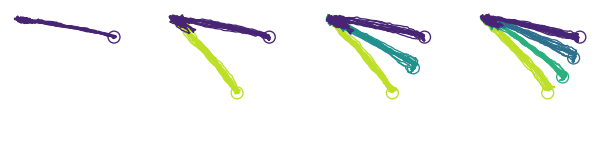

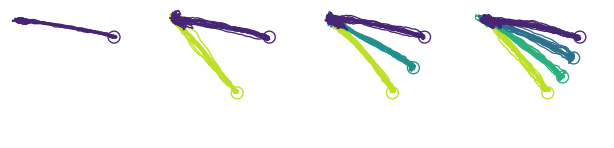

In [16]:
axs, params = dt.graph_outputs_all(seed_ex, 'uni_rad', repertoires)
plt.savefig(SUBFIG_DIR + "output_" + params +'.pdf', format='pdf')

axs, params = dt.graph_outputs_all(seed_ex, 'uni_onehot', repertoires)
plt.savefig(SUBFIG_DIR + "output_" + params +'.pdf', format='pdf')


#### Loss during adaptation

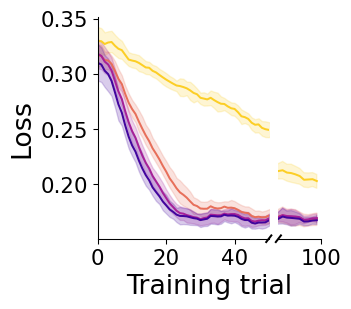

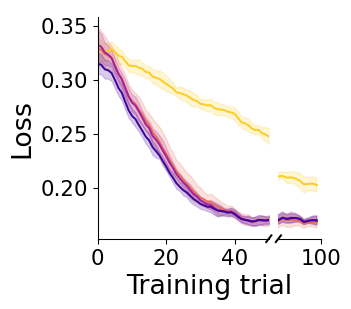

In [17]:
_, _, params = dt.graph_loss_broken_axis(seeds, 'uni_rad', repertoires, 'rotation', 10.0, 'v1', smooth=True, rel_loss = False)
plt.savefig(SUBFIG_DIR + "loss_"+params+".pdf", format='pdf', bbox_inches='tight' )

_, _, params = dt.graph_loss_broken_axis(seeds, 'uni_onehot', repertoires, 'rotation', 10.0, 'v1', smooth=True, rel_loss = False)
plt.savefig(SUBFIG_DIR + "loss_"+params+".pdf", format='pdf', bbox_inches='tight' )


In [18]:
def compare_simsets(data, reps, y):
    plt.figure(figsize = (3,3))

    for i, sim_set in enumerate(['uni_rad', 'uni_onehot']):
        df = data[(data.sim_set == sim_set)]
        
        colors = Constants.REPERTOIRE_COLORS[1:]             
        g = sns.swarmplot(x="repertoire", y=y, data=df, palette = colors, alpha = 0.4, 
            marker = 'o' if i == 0 else '^')

        g= dt.pointplot_across_repertoires(df, reps, y, 
            'grey' if i == 0 else 'lightgrey', ['solid'] if i == 0 else ['dashed'], ax = g)

        #stats 
        for i, rep1 in enumerate(reps):
            for j, rep2 in enumerate(reps[i+1:]):
                a = df[(df.repertoire == rep1)]
                b = df[(df.repertoire == rep2)]
                a_measure = a[y].values
                b_measure = b[y].values

                print(scipy.stats.shapiro(a_measure))
                _, pnorm = scipy.stats.ttest_rel(a_measure, b_measure)
                print(y, '\t', abr_dict[rep1], '\t', abr_dict[rep2], '\t', pnorm)
        print('\n') 

    # set ordering
    plt.setp(g.lines[:2], zorder=0)
    plt.setp(g.lines[4:6], zorder=0)
    plt.setp(g.collections[3], alpha=.5)
    plt.setp(g.lines[5:], alpha=.5)
    return g
    

### Compare measures between networks with angular or categorical inputs

In [22]:
def compare_simsets(data, reps, y):
    plt.figure(figsize = (3,3))

    for i, sim_set in enumerate(['uni_rad', 'uni_onehot']):
        df = data[(data.sim_set == sim_set)]
        
        colors = Constants.REPERTOIRE_COLORS[1:]             
        g = sns.swarmplot(x="repertoire", y=y, data=df, palette = colors, alpha = 0.4, 
            marker = 'o' if i == 0 else '^')


        g= dt.pointplot_across_repertoires(df, reps, y, 
            'grey' if i == 0 else 'lightgrey', 'solid' if i == 0 else 'dashed', ax = g)

        #stats 
        for i, rep1 in enumerate(reps):
            for j, rep2 in enumerate(reps[i+1:]):
                a = df[(df.repertoire == rep1)]
                b = df[(df.repertoire == rep2)]
                a_measure = a[y].values
                b_measure = b[y].values

                print(scipy.stats.shapiro(a_measure))
                _, pnorm = scipy.stats.ttest_rel(a_measure, b_measure)
                print(y, '\t', abr_dict[rep1], '\t', abr_dict[rep2], '\t', pnorm)
        print('\n') 

    # set ordering
    plt.setp(g.lines[:2], zorder=0)
    plt.setp(g.lines[4:6], zorder=0)
    plt.setp(g.collections[3], alpha=.5)
    plt.setp(g.lines[5:], alpha=.5)
    return g
    

#### Decay constant

In [23]:
#exponential function
def exp_func(t, A, K, C):
    return A * np.exp(K * t) + C

smooth = True
learn_set = None
perturbation = 'rotation'
pert_param = 10.0
pert_set = 'v1'

reps = Constants.UNIS[1:]

rows_list = []
colormap = dt.get_colormap(reps, 'plasma_r')
for sim_set in ['uni_rad', 'uni_onehot']:
    for seed in seeds:
        for repertoire in reps:

            # decay constant
            try:
                loss = dt.get_loss(seed, sim_set, repertoire, perturbation, pert_param, pert_set, smooth = smooth)
            except:
                print('failed', seed, sim_set, repertoire)
                continue
            t = np.arange(1,len(loss)+1)
            ## exponential fit
            p0 = (0.1,-0.1,0.2) # starting search koefs
            opt, pcov =  scipy.optimize.curve_fit(exp_func, t, loss, p0)
            A, K, C = opt
            fit_y = exp_func(t, A, K, C)

            # relative weight change
            outdir = dt.get_outdir(seed, sim_set, repertoire, perturbation, pert_param, pert_set)
            init_weights = dt.get_model_weights(outdir,before_training=True)['rec']
            dws = dt.get_weight_changes(outdir)['rec']
            rel_dw = dt.rel_dw(dws, init_weights)
            rel_dw_med_abs = np.median(np.abs(rel_dw))

            temp = {
                'seed': seed,
                'sim_set': sim_set,
                'repertoire': repertoire,
                'perturbation': perturbation,
                'pert_param': pert_param,
                'pert_set': pert_set,
                'decay': K,
                'rel_dw_med_abs': rel_dw_med_abs
            }
            rows_list.append(temp)

df = pd.DataFrame(rows_list)


ShapiroResult(statistic=0.893001851745035, pvalue=0.1832563149321222)
decay 	 2 Mov. 	 3 Mov. 	 5.351829339524469e-06
ShapiroResult(statistic=0.893001851745035, pvalue=0.1832563149321222)
decay 	 2 Mov. 	 4 Mov. 	 6.411937916858163e-07
ShapiroResult(statistic=0.9675986662593229, pvalue=0.8677315675974464)
decay 	 3 Mov. 	 4 Mov. 	 0.028760204059884303


ShapiroResult(statistic=0.9028023330618168, pvalue=0.23511237532414148)
decay 	 2 Mov. 	 3 Mov. 	 0.08663431655710067
ShapiroResult(statistic=0.9028023330618168, pvalue=0.23511237532414148)
decay 	 2 Mov. 	 4 Mov. 	 0.04006779493008581
ShapiroResult(statistic=0.9163174316904651, pvalue=0.32726137934367544)
decay 	 3 Mov. 	 4 Mov. 	 0.29015868058938965




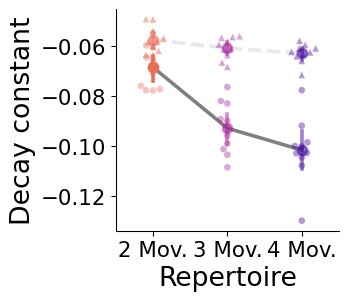

In [24]:
%matplotlib inline
#plot decay rate (mean)
g = compare_simsets(df, repertoires[1:], 'decay')
g.set_ylabel('Decay constant')
params = '_'.join(filter(None, [perturbation, pert_set, str(pert_param) if pert_param else None]))
plt.savefig(SUBFIG_DIR + "decay_constant.pdf", format='pdf', bbox_inches='tight' )
#normal


#### Relative weight change

ShapiroResult(statistic=0.9336350637598275, pvalue=0.48458311541824634)
rel_dw_med_abs 	 2 Mov. 	 3 Mov. 	 5.769641661977996e-07
ShapiroResult(statistic=0.9336350637598275, pvalue=0.48458311541824634)
rel_dw_med_abs 	 2 Mov. 	 4 Mov. 	 1.8006838769271315e-07
ShapiroResult(statistic=0.9412719541762886, pvalue=0.5672518354900227)
rel_dw_med_abs 	 3 Mov. 	 4 Mov. 	 0.14227754115844662


ShapiroResult(statistic=0.9575364587887205, pvalue=0.7574585807511007)
rel_dw_med_abs 	 2 Mov. 	 3 Mov. 	 0.31644313625911463
ShapiroResult(statistic=0.9575364587887205, pvalue=0.7574585807511007)
rel_dw_med_abs 	 2 Mov. 	 4 Mov. 	 0.30920785515736693
ShapiroResult(statistic=0.91911566186005, pvalue=0.349638203866269)
rel_dw_med_abs 	 3 Mov. 	 4 Mov. 	 0.8668571405632218




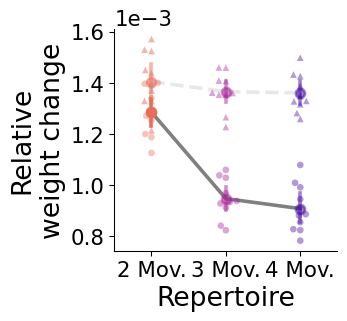

In [25]:
#plot relative weight change (mean of median)
g = compare_simsets(df, repertoires[1:], 'rel_dw_med_abs')
g.set_ylabel("\n".join(wrap('Relative weight change',14)))
params = '_'.join(filter(None, [perturbation, pert_set, str(pert_param) if pert_param else None]))
plt.savefig(SUBFIG_DIR + "rel_weight_change.pdf", format='pdf', bbox_inches='tight' )
#normal


#### Deviation angle

ShapiroResult(statistic=0.9932159532540409, pvalue=0.9993140689992046)
dev_angle 	 2 Mov. 	 3 Mov. 	 0.0023461602132193067
ShapiroResult(statistic=0.9932159532540409, pvalue=0.9993140689992046)
dev_angle 	 2 Mov. 	 4 Mov. 	 9.926041806028652e-05
ShapiroResult(statistic=0.8899754550290394, pvalue=0.16946857593371023)
dev_angle 	 3 Mov. 	 4 Mov. 	 0.21982435871574224


ShapiroResult(statistic=0.9160944996670976, pvalue=0.3255289906052515)
dev_angle 	 2 Mov. 	 3 Mov. 	 0.05711088142714176
ShapiroResult(statistic=0.9160944996670976, pvalue=0.3255289906052515)
dev_angle 	 2 Mov. 	 4 Mov. 	 0.0015889171426543094
ShapiroResult(statistic=0.9198806740640391, pvalue=0.3559607419499054)
dev_angle 	 3 Mov. 	 4 Mov. 	 0.0096919683246002




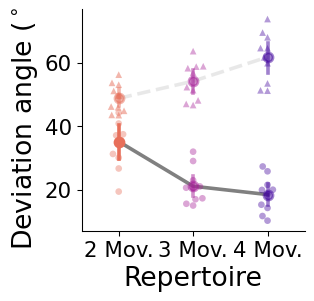

In [26]:
#plot deviation angle (mean of medians)
with open(Constants.PROCESSED_DATA_FOLDER + 'uni_rad/deviation_angle.pickle', 'rb') as f:
    angles_df_rad = pickle.load(f)
with open(Constants.PROCESSED_DATA_FOLDER + 'uni_onehot/deviation_angle.pickle', 'rb') as f:
    angles_df_onehot = pickle.load(f)
angles_df = pd.concat([angles_df_rad, angles_df_onehot])
angles_df['dev_angle'] = angles_df.apply(lambda row:np.median(row.angle), axis = 1)

g = compare_simsets(angles_df, repertoires[1:], 'dev_angle')
g.set_ylabel('Deviation angle ($^\circ$)')
params = '_'.join(filter(None, [perturbation, pert_set, str(pert_param) if pert_param else None]))
plt.savefig(SUBFIG_DIR + "deviation_angle.pdf", format='pdf', bbox_inches='tight' )